In [33]:
#  STEP 1: Install dependencies
# ! pip install rasterio tensorflow scikit-learn tqdm

#  STEP 2: Imports
import os
import numpy as np
import rasterio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

#  STEP 3: Load all NDVI GeoTIFFs into a 3D array
from google.colab import drive
drive.mount('/content/drive')

# Unzip NDVI files from Google Drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the unzipped folder in Drive
folder = "/content/drive/MyDrive/EVI_LSTM_2"

# List all .tif files
files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
print(files)

# print(files)
# exit()

ndvi_stack = []

print("Reading MNDVI images...")
# for f in tqdm(files):
#     with rasterio.open(os.path.join(folder, f)) as src:
#         ndvi_read = src.read(1)  # Reads the first band (common for NDVI)
#         profile = src.profile
#         print(ndvi_read, "\n\n\n\n\n")
#         ndvi_stack.append(ndvi_read)

# # print(ndvi_stack)
# ndvi_stack = np.array(ndvi_stack)  # Shape: [time, height, width]
# time, height, width = ndvi_stack.shape

# print(f"Loaded NDVI stack with shape: {ndvi_stack.shape}")

# for f in files:
#     with rasterio.open(os.path.join(folder, f)) as src:
#         data = src.read(1).astype('float32')
#         nan_count = np.isnan(data).sum()
#         valid_count = np.count_nonzero(~np.isnan(data))

#         unique = np.unique(data)

#         print(np.nanmin(unique))
#         print(np.nanmax(unique))

#         print("NaN values:", nan_count)
#         print("Valid (non-NaN) values:", valid_count)
#         print(src.nodata)
#         ref_mask = np.isnan(data)
#         break

# for f in files[1:]:
#     with rasterio.open(os.path.join(folder, f)) as src:
#         data = src.read(1).astype('float32')
#         nan_count = np.isnan(data).sum()
#         valid_count = np.count_nonzero(~np.isnan(data))

#         unique = np.unique(data)

#         print(np.nanmin(unique))
#         print(np.nanmax(unique))

#         print("NaN values:", nan_count)
#         print("Valid (non-NaN) values:", valid_count)
#         print(src.nodata)
#         current_mask = np.isnan(data)
#         if not np.array_equal(ref_mask, current_mask):
#             print(f"Inconsistent NaN positions in file: {f}")
#             consistent = False
#             break


for f in files:
    with rasterio.open(os.path.join(folder, f)) as src:
        data = src.read(1).astype('float32')
        ndvi_stack.append(data)

print(type(ndvi_stack[0]))
ndvi_stack = np.array(ndvi_stack)  # Shape: [time, height, width]
time, height, width = ndvi_stack.shape

print(f"Loaded MNDWI stack with shape: {ndvi_stack.shape}")

print("MNDWI shape:", ndvi_stack.shape)
print("MNDWI stats:", np.nanmin(ndvi_stack), np.nanmax(ndvi_stack))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['EVI_07_July_2024_Krishna.tif', 'EVI_08_Aug_2024_Krishna.tif', 'EVI_09_Sep_2024_Krishna.tif', 'EVI_10_Oct_2024_Krishna.tif', 'EVI_11_Nov_2024_Krishna.tif', 'EVI_12_Dec_2024_Krishna.tif']
Reading MNDVI images...
<class 'numpy.ndarray'>
Loaded MNDWI stack with shape: (6, 5308, 5811)
MNDWI shape: (6, 5308, 5811)
MNDWI stats: -255283730000000.0 97995520000000.0


In [34]:
ndvi_stack

for i, layer in enumerate(ndvi_stack):
    nans = np.isnan(layer).sum()
    print(f"Time step {i}: {nans} NaN values")

total_nans = np.isnan(ndvi_stack).sum()
print("Total NaN values in NDVI stack:", total_nans)

total_pixels = np.prod(ndvi_stack.shape)
nan_percentage = (total_nans / total_pixels) * 100
print(f"Percentage of NaN values: {nan_percentage:.2f}%")



Time step 0: 21023783 NaN values
Time step 1: 21023707 NaN values
Time step 2: 21023607 NaN values
Time step 3: 21023786 NaN values
Time step 4: 21023765 NaN values
Time step 5: 21023628 NaN values
Total NaN values in NDVI stack: 126142276
Percentage of NaN values: 68.16%


(6, 5308, 5811)
Pixels that are NaN in ALL timesteps: 21023606


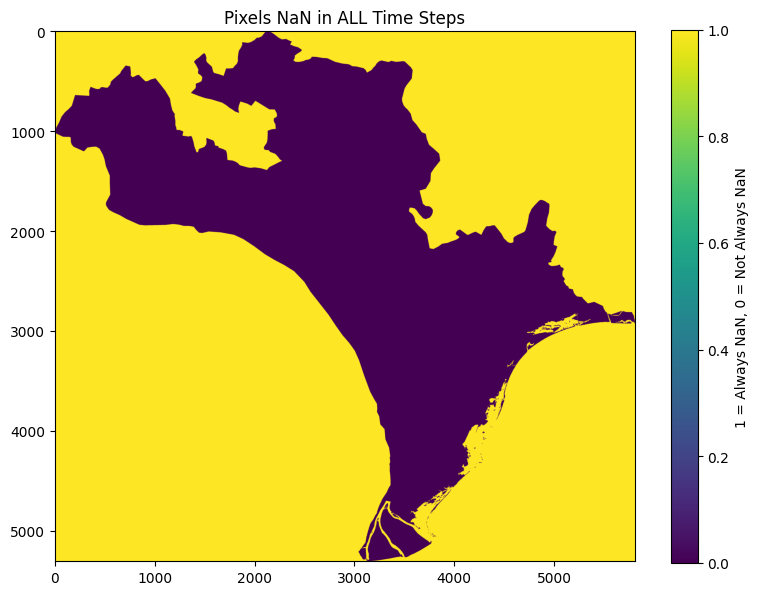

In [35]:
nan_masks = np.isnan(ndvi_stack)  # (time, height, width)
print(nan_masks.shape)

# --- Check where all time steps are NaN ---
consistent_nan_mask = np.all(nan_masks, axis=0)  # (height, width)
consistent_nan_count = np.sum(consistent_nan_mask)
print("Pixels that are NaN in ALL timesteps:", consistent_nan_count)

# --- Optional: visualize consistent NaN locations ---
plt.figure(figsize=(8, 6))
plt.imshow(consistent_nan_mask, cmap='viridis')
plt.title("Pixels NaN in ALL Time Steps")
plt.colorbar(label="1 = Always NaN, 0 = Not Always NaN")
plt.tight_layout()
plt.show()

In [36]:
ndvi_scaled = np.empty_like(ndvi_stack, dtype=np.float32)
mins = np.full((height, width), np.nan, dtype=np.float32)
maxs = np.full((height, width), np.nan, dtype=np.float32)

print("Normalizing pixels with NumPy...")
for i in tqdm(range(height)):
    for j in range(width):
        series = ndvi_stack[:, i, j]
        if np.isnan(series).any() or np.all(series == 0):
            ndvi_scaled[:, i, j] = np.nan
            continue
        min_val = np.nanmin(series)
        max_val = np.nanmax(series)
        if max_val - min_val == 0:
            ndvi_scaled[:, i, j] = np.nan
        else:
            ndvi_scaled[:, i, j] = (series - min_val) / (max_val - min_val)
            mins[i, j] = min_val
            maxs[i, j] = max_val


Normalizing pixels with NumPy...


100%|██████████| 5308/5308 [06:18<00:00, 14.04it/s]


In [37]:
import os
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt



normalized=True
seq_length = 5  # Use 5 months to predict the 6th
X_all = []
y_all = []
coords_all = []
# valid_mask = np.ones((height, width), dtype=bool)
# for t in range(time):
#     valid_mask = valid_mask & ~np.isnan(ndvi_scaled[t])
print("Preparing training data...")
for i in tqdm(range(height)):
    for j in range(width):
        # if not valid_mask[i, j]:
        #     continue
        if normalized:
            series=ndvi_scaled[:, i, j]
        else:
            series = ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use first 5 months to predict the 6th month
        X_all.append(series[:seq_length])
        y_all.append(series[seq_length])
        coords_all.append([i, j])

# Convert to numpy arrays and reshape for LSTM
X_all = np.array(X_all).reshape(-1, seq_length, 1)
y_all = np.array(y_all)
coords_all = np.array(coords_all)

print(f"Training data prepared: X shape: {X_all.shape}, y shape: {y_all.shape}")


Preparing training data...


100%|██████████| 5308/5308 [01:51<00:00, 47.46it/s]


Training data prepared: X shape: (9820542, 5, 1), y shape: (9820542,)


In [38]:

def create_lstm_model(seq_length):
    pixel_input = Input(shape=(seq_length, 1))  # NDVI time series input
    coord_input = Input(shape=(2,))  # Pixel coordinates (i, j)

    # LSTM layers
    # lstm_1 = LSTM(50, return_sequences=True)(pixel_input)
    lstm_1 = LSTM(32, return_sequences=True)(pixel_input)
    lstm_2 = LSTM(50)(lstm_1)

    # Concatenate LSTM output with coordinates for spatial awareness
    concat = Concatenate()([lstm_2, coord_input])

    # Output layer
    output = Dense(1)(concat)

    # Define the model
    model = tf.keras.Model(inputs=[pixel_input, coord_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

print("Training LSTM model...")
model = create_lstm_model(seq_length)
model.fit(
    [X_all,coords_all],
    y_all,
    validation_split = 0.2,
    epochs=5,
    batch_size=2048,
    verbose=1
)
model_path = "ndvi_lstm_model_normalized.keras"
model.save(model_path)

Training LSTM model...
Epoch 1/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - loss: 208999.8281 - val_loss: 182.3950
Epoch 2/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 45.1972 - val_loss: 4.9031
Epoch 3/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.6216 - val_loss: 0.1139
Epoch 4/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1047 - val_loss: 0.1142
Epoch 5/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.1004 - val_loss: 0.1037


In [39]:
predicted = np.full((height, width), np.nan, dtype=np.float32)
print("prepring data for Predicting NDVI for the 7th month...")
X_test=[]
coords_test = []

for i in tqdm(range(height)):
    for j in range(width):
        if normalized:
            series=ndvi_scaled[:,i,j]
        else:
            series = ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use all 6 months to predict the 7th month

        X_test.append(series[1:])
        coords_test.append([i,j])

        # # Inverse transform the prediction to original scale
        # if scalers[i, j] is not None:
        #     predicted[i, j] = scalers[i, j].inverse_transform(pred_scaled.reshape(-1, 1))[0][0]

X_test = np.array(X_test).reshape(-1, seq_length, 1)
coords_test = np.array(coords_test)

prepring data for Predicting NDVI for the 7th month...


100%|██████████| 5308/5308 [01:48<00:00, 48.88it/s]


In [40]:
print("predicting for 7th month")
y_pred = model.predict([X_test, coords_test], batch_size=2048, verbose=1)

print("converting back to 2d grid")
print(y_pred.shape)
for idx, (i, j) in tqdm(enumerate(coords_test)):
    if normalized:
        min_val = mins[i, j]
        max_val = maxs[i, j]
        assert not np.isnan(min_val) and not np.isnan(max_val)
        predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
    else:
        predicted[i, j] = y_pred[idx]

predicting for 7th month
4796/4796 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step
converting back to 2d grid
(9820542, 1)


0it [00:00, ?it/s]<ipython-input-40-2dbf15bb067a>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
9820542it [01:33, 104597.04it/s]


Saving prediction to GeoTIFF...
✅ Prediction saved as: predicted_mndwi_month1_2023_normalized.tif


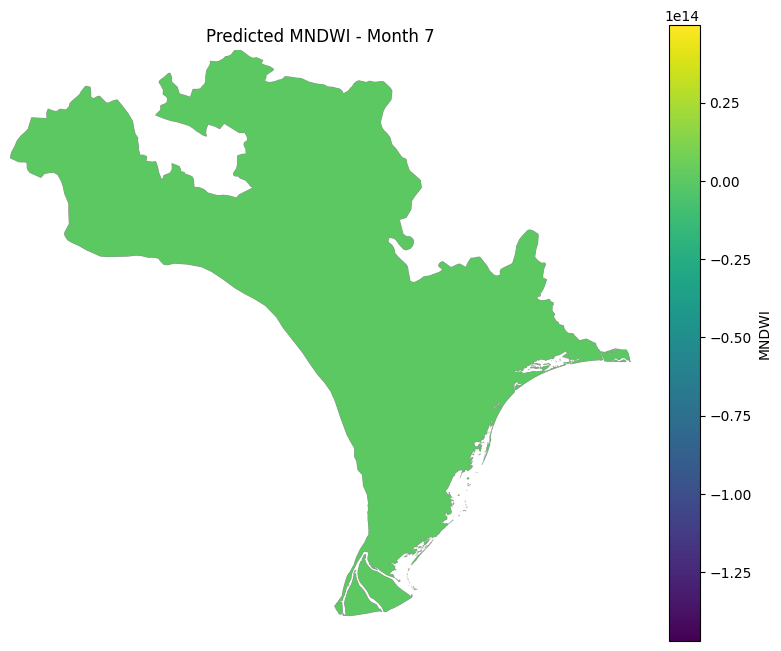

In [41]:
# STEP 6: Save prediction as GeoTIFF
print("Saving prediction to GeoTIFF...")#
# Use last image as template
with rasterio.open(os.path.join(folder, files[-1])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open("predicted_evi_month1_2025_normalized.tif", "w", **profile) as dst:
        dst.write(predicted.astype(np.float32), 1)#
print("✅ Prediction saved as: predicted_mndwi_month1_2023_normalized.tif")#
# STEP 7: Preview the prediction
plt.figure(figsize=(10, 8))
plt.imshow(predicted, cmap='viridis')
plt.colorbar(label='MNDWI')
plt.title("Predicted MNDWI - Month 7")
plt.axis('off')
plt.savefig("predicted_mndwi_month1.png", dpi=300)
plt.show()

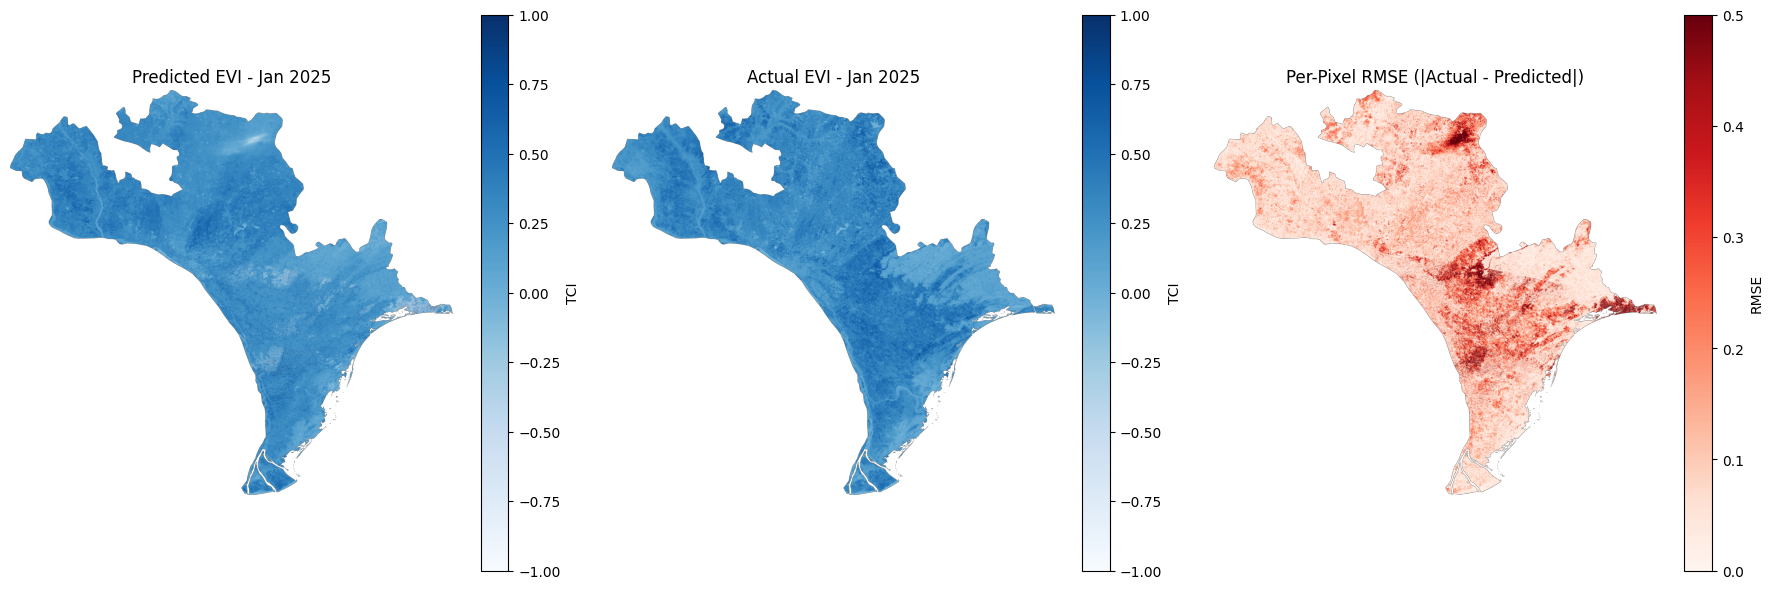

In [42]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load both rasters
predicted_path = "/content/predicted_evi_month1_2025_normalized.tif"
actual_path = "/content/drive/MyDrive/EVI_LSTM_2025/EVI_01_Jan_2025_Krishna.tif"  # Adjust to actual path

with rasterio.open(predicted_path) as src:
    predicted = src.read(1)
    profile = src.profile


with rasterio.open(actual_path) as src:
    actual = src.read(1)

# 2. Visual comparison - Side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Predicted NDWI
im1 = ax1.imshow(predicted, cmap='Blues', vmin=-1, vmax=1)
ax1.set_title('Predicted EVI - Jan 2025')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, label='TCI')

# Actual NDWI
im2 = ax2.imshow(actual, cmap='Blues', vmin=-1, vmax=1)
ax2.set_title('Actual EVI - Jan 2025')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, label='TCI')

# Replace this section in your code

# Compute squared error per pixel, ignoring NaNs
error_squared = np.where(~np.isnan(predicted) & ~np.isnan(actual), (actual - predicted) ** 2, np.nan)
rmse_map = np.sqrt(error_squared)  # This is effectively abs(error) for a single timestep

# Plot RMSE map
im3 = ax3.imshow(rmse_map, cmap='Reds', vmin=0, vmax=0.5)
ax3.set_title('Per-Pixel RMSE (|Actual - Predicted|)')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, label='RMSE')

plt.tight_layout()
plt.savefig("mndwi_07_2023.png", dpi=300)
plt.show()

In [48]:
# ! pip install rasterio tensorflow scikit-learn tqdm

import os
import numpy as np
import rasterio
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# Define month-year keys
time_keys = ['2022_Jul', '2023_Jan', '2023_Jul', '2024_Jan', '2024_Jul', '2025_Jan']

# Define paths for each time point
file_paths = {
    '2022_Jul': {
        'pred': "/content/predicted_mndvi_month7_2022_normalized.tif",
        'act':  "/content/drive/MyDrive/MNDWI_LSTM_2022_2/MNDWI_07July_2022_Krishna.tif"
    },
    '2023_Jan': {
        'pred': "/content/predicted_mndvi_month1_2023_normalized.tif",
        'act':  "/content/drive/MyDrive/MNDWI_LSTM_2023/MNDWI_01January_2023_Krishna.tif"
    },
    '2023_Jul': {
        'pred': "/content/predicted_mndvi_month7_2023_normalized.tif",
        'act':  "/content/drive/MyDrive/MNDWI_LSTM_2023_2/MNDWI_07July_2023_Krishna.tif"
    },
    '2024_Jan': {
        'pred': "/content/predicted_mndvi_month1_2024_normalized.tif",
        'act':  "/content/drive/MyDrive/MNDWI_LSTM_2024/MNDWI_01January_2024_Krishna.tif"
    },
    '2024_Jul': {
        'pred': "/content/predicted_mndvi_month7_2024_normalized.tif",
        'act':  "/content/drive/MyDrive/MNDWI_LSTM_2024_2/MNDWI_07July_2024_Krishna.tif"
    },
    '2025_Jan': {
        'pred': "/content/predicted_mndvi_month1_2025_normalized.tif",
        'act':  "/content/drive/MyDrive/MNDWI_LSTM_2025/MNDWI_01January_2025_Krishna.tif"
    }
}

# Define error threshold (in NDVI units)
threshold = 0.4

results = []

for key in time_keys:
    with rasterio.open(file_paths[key]['pred']) as src_pred:
        pred = src_pred.read(1)
    with rasterio.open(file_paths[key]['act']) as src_act:
        act = src_act.read(1)

    # Mask valid pixels
    mask = ~np.isnan(pred) & ~np.isnan(act)
    y_true = act[mask].flatten()
    y_pred = pred[mask].flatten()

    # Threshold-based accuracy
    abs_error = np.abs(y_pred - y_true)
    accurate_pixels = abs_error < threshold
    pixel_accuracy = np.sum(accurate_pixels) / len(y_true)

    # Store results
    year, month = key.split('_')
    results.append({
        'Year': year,
        'Month': month,
        'Accuracy': pixel_accuracy
    })

# Convert to DataFrame
df = pd.DataFrame(results)
table_acc = df.pivot(index='Year', columns='Month', values='Accuracy')
print(f"\nAccuracy Table for MNDWI(Threshold = {threshold}):\n", table_acc.round(4))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Accuracy Table for MNDWI(Threshold = 0.4):
 Month     Jan     Jul
Year                 
2022      NaN  0.9067
2023   0.9049  0.5304
2024   0.6879  0.8926
2025   0.8046     NaN
